In [1]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Load in the data 

In [6]:
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
# Reshape the data to a 28x28 image
image_index = 3  # You can change this index to display different images
image = X.iloc[image_index].to_numpy().reshape(28, 28)



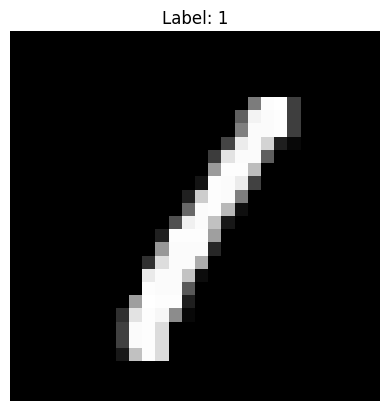

In [16]:
# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {y[image_index]}')
plt.axis('off')  # Hide the axes
plt.show()

In [18]:
X = X.values.reshape(-1, 28, 28)  # Make sure X is reshaped into 28x28 images


In [19]:
# Define the function to extract 5x5 patches
def extract_patches(images, patch_size=5):
    patches = []
    for image in images:
        for i in range(image.shape[0] - patch_size + 1):
            for j in range(image.shape[1] - patch_size + 1):
                patch = image[i:i + patch_size, j:j + patch_size]
                if np.sum(patch) > 0:  # Filter out all-zero patches
                    patches.append(patch.flatten())
    return np.array(patches)

# Extract patches
patches = extract_patches(X)

# Check what the patches look like 

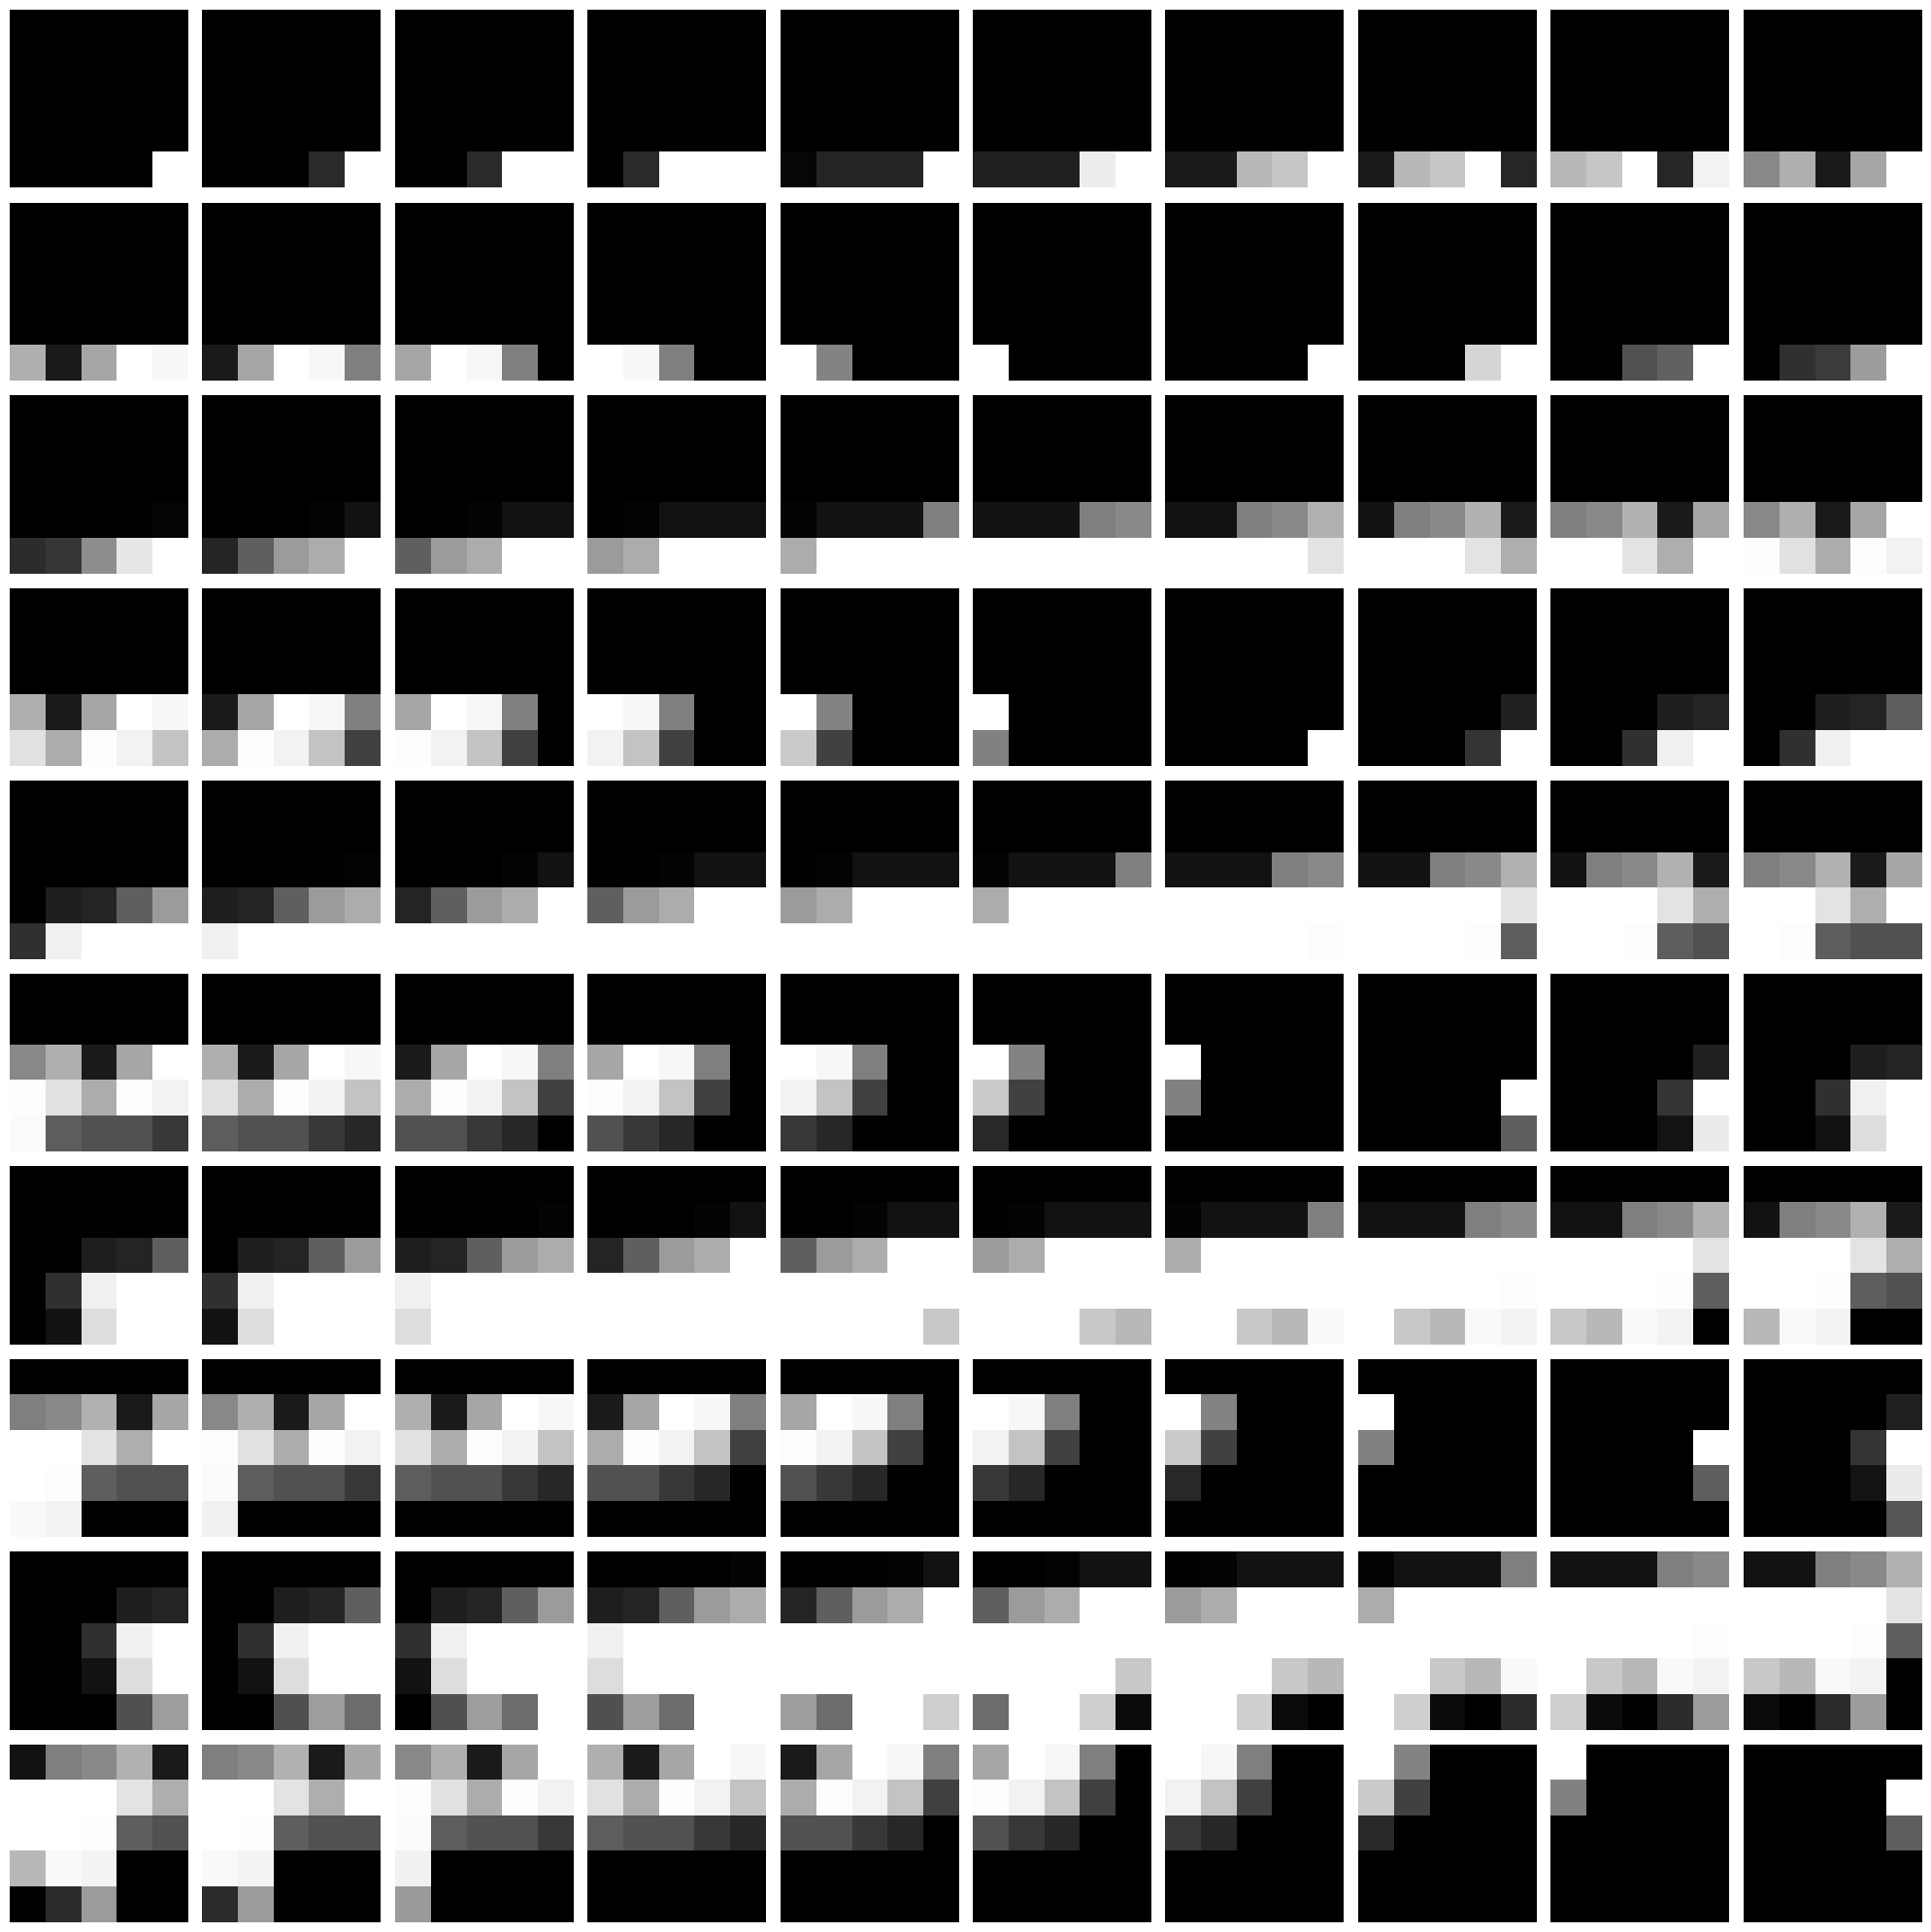

In [23]:
def plot_patches(patches, num_patches=25):
    # Calculate the number of rows and columns to display
    num_rows = int(np.sqrt(num_patches))
    num_cols = int(np.ceil(num_patches / num_rows))

    # Set up the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.ravel()  # Flatten the array of axes

    # Plot each patch
    for i in range(num_patches):
        if i < len(patches):
            patch = patches[i].reshape(5, 5)  # Reshape back to 5x5
            axes[i].imshow(patch, cmap='gray', interpolation='nearest')
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide axes for empty subplots

    plt.tight_layout()
    plt.show()

plot_patches(patches, num_patches=100)  # Change num_patches as needed


In [26]:
len(patches)

23426010

In [27]:
image.shape[0] 

28

### Save patches since it took four minutes to compute 

In [28]:
#np.save('mnist_patches.npy', patches)

In [2]:
patches = np.load('mnist_patches.npy')


# Normalize Patches 

In [3]:
norms = np.linalg.norm(patches, axis = 1, keepdims= True) #compute the norm 
patches = patches / norms

In [4]:
sample_size = int(0.01 * patches.shape[0])  # 1% sample
sample_indices = np.random.choice(patches.shape[0], sample_size, replace=False)
sampled_patches = patches[sample_indices]


In [6]:
# Assuming 'patches' is your full dataset
sample_size = int(0.01 * patches.shape[0])  # 1% sample
sample_indices = np.random.choice(patches.shape[0], sample_size, replace=False)
sampled_patches = patches[sample_indices]

In [11]:
def perform_kmeans_clustering(data, k_values):
    models = {}
    for k in k_values:
        print(f"Clustering with k = {k}...")
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        models[k] = kmeans
        print(f"Done clustering with k = {k}.")
    return models

k_values = [100, 500, 1000, 5000, 10000]
models = perform_kmeans_clustering(sampled_patches, k_values)

save_models(models)

Clustering with k = 100...


/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done clustering with k = 100.
Clustering with k = 500...


/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done clustering with k = 500.
Clustering with k = 1000...


/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done clustering with k = 1000.
Clustering with k = 5000...


/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done clustering with k = 5000.
Clustering with k = 10000...


/Users/shawheennaderi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Done clustering with k = 10000.
Model with k=100 saved to models/kmeans_k100.joblib
Model with k=500 saved to models/kmeans_k500.joblib
Model with k=1000 saved to models/kmeans_k1000.joblib
Model with k=5000 saved to models/kmeans_k5000.joblib
Model with k=10000 saved to models/kmeans_k10000.joblib


In [6]:
from joblib import dump

def save_models(models, base_path="models/"):
    import os
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    for k, model in models.items():
        filename = f"{base_path}kmeans_k{k}.joblib"
        dump(model, filename)
        print(f"Model with k={k} saved to {filename}")

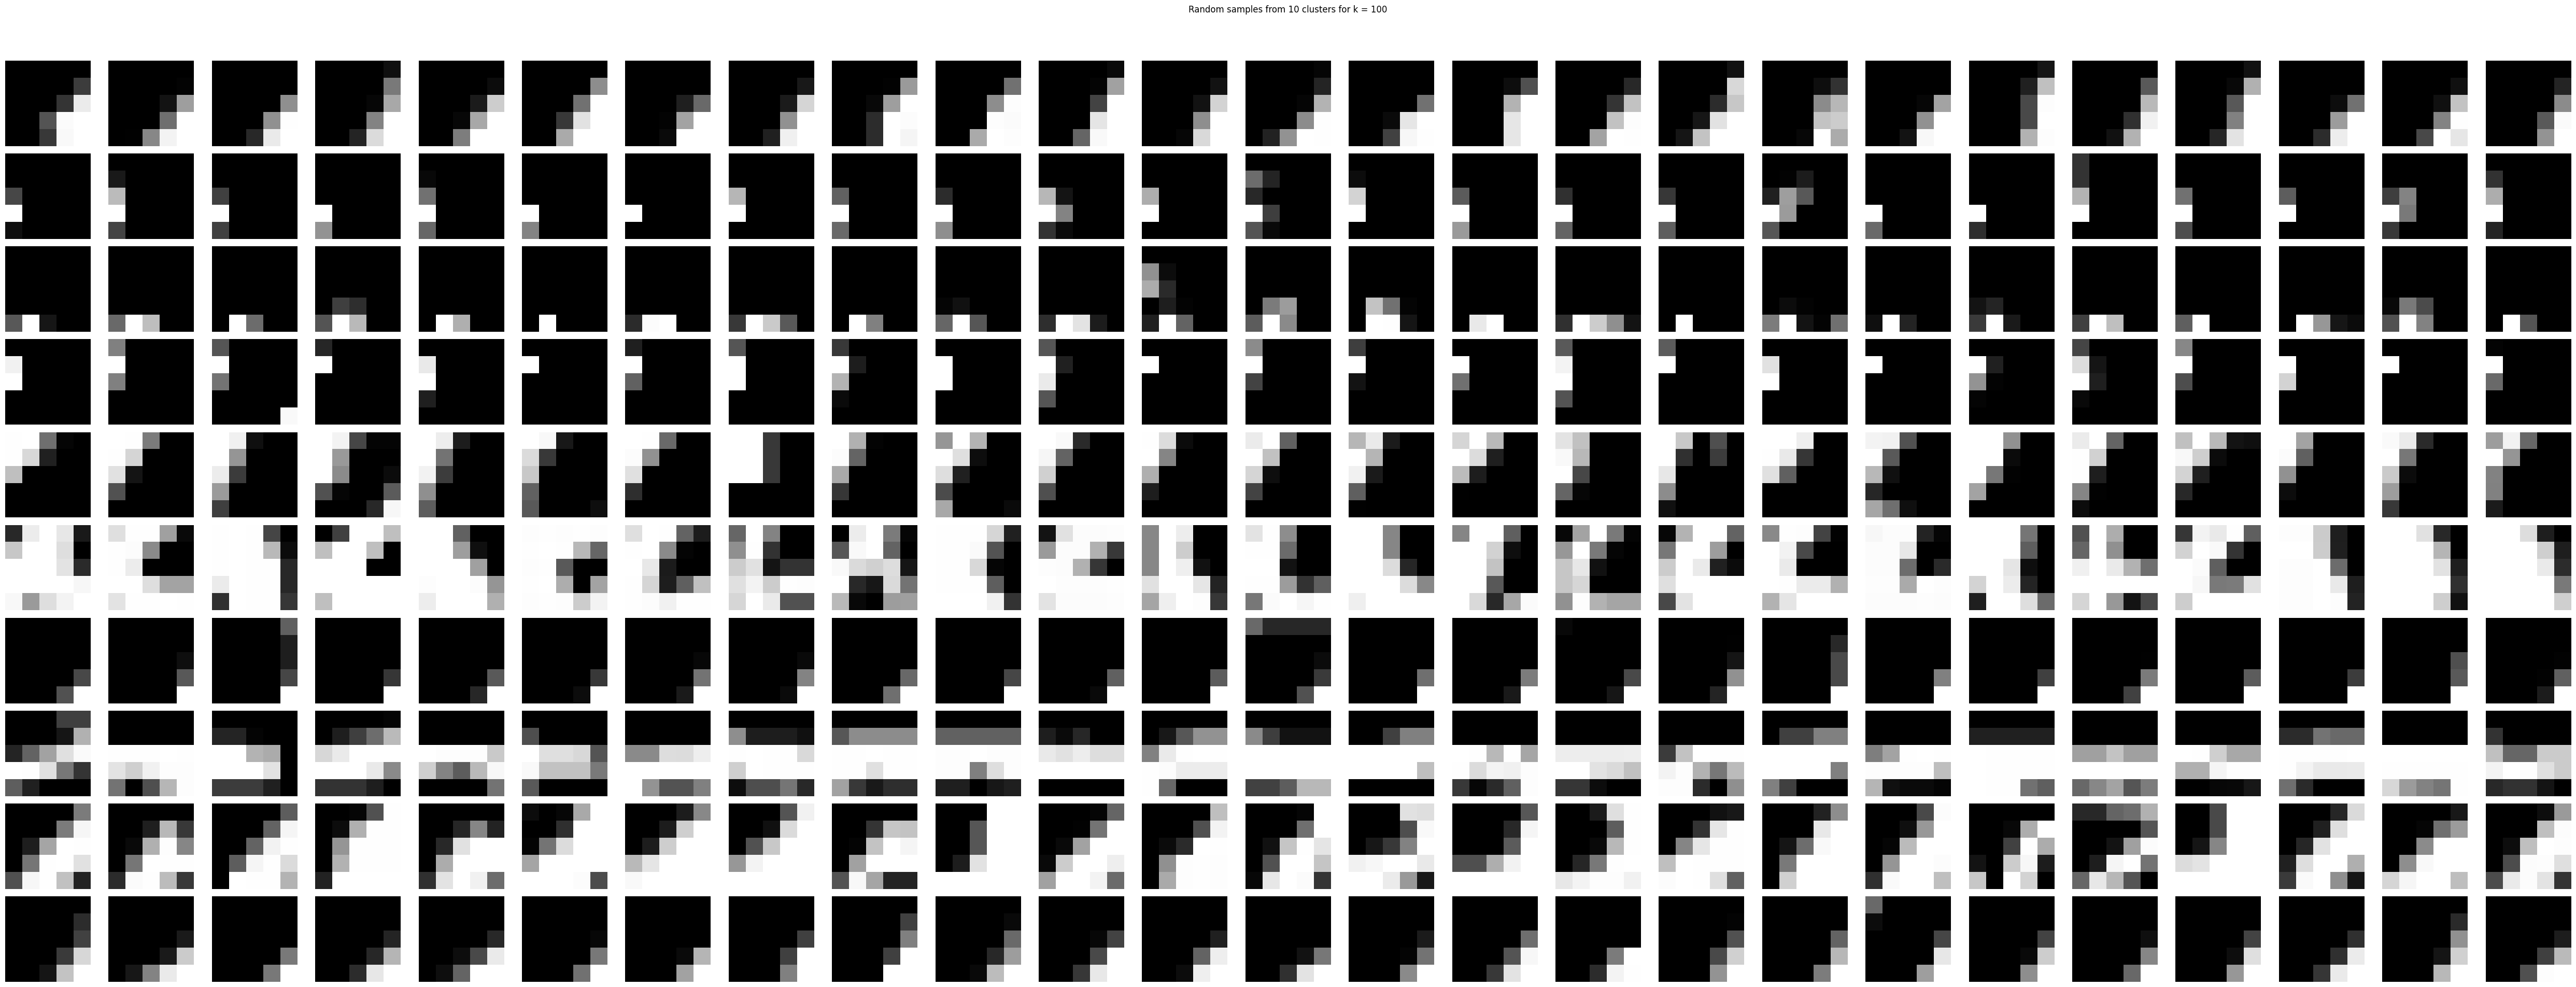

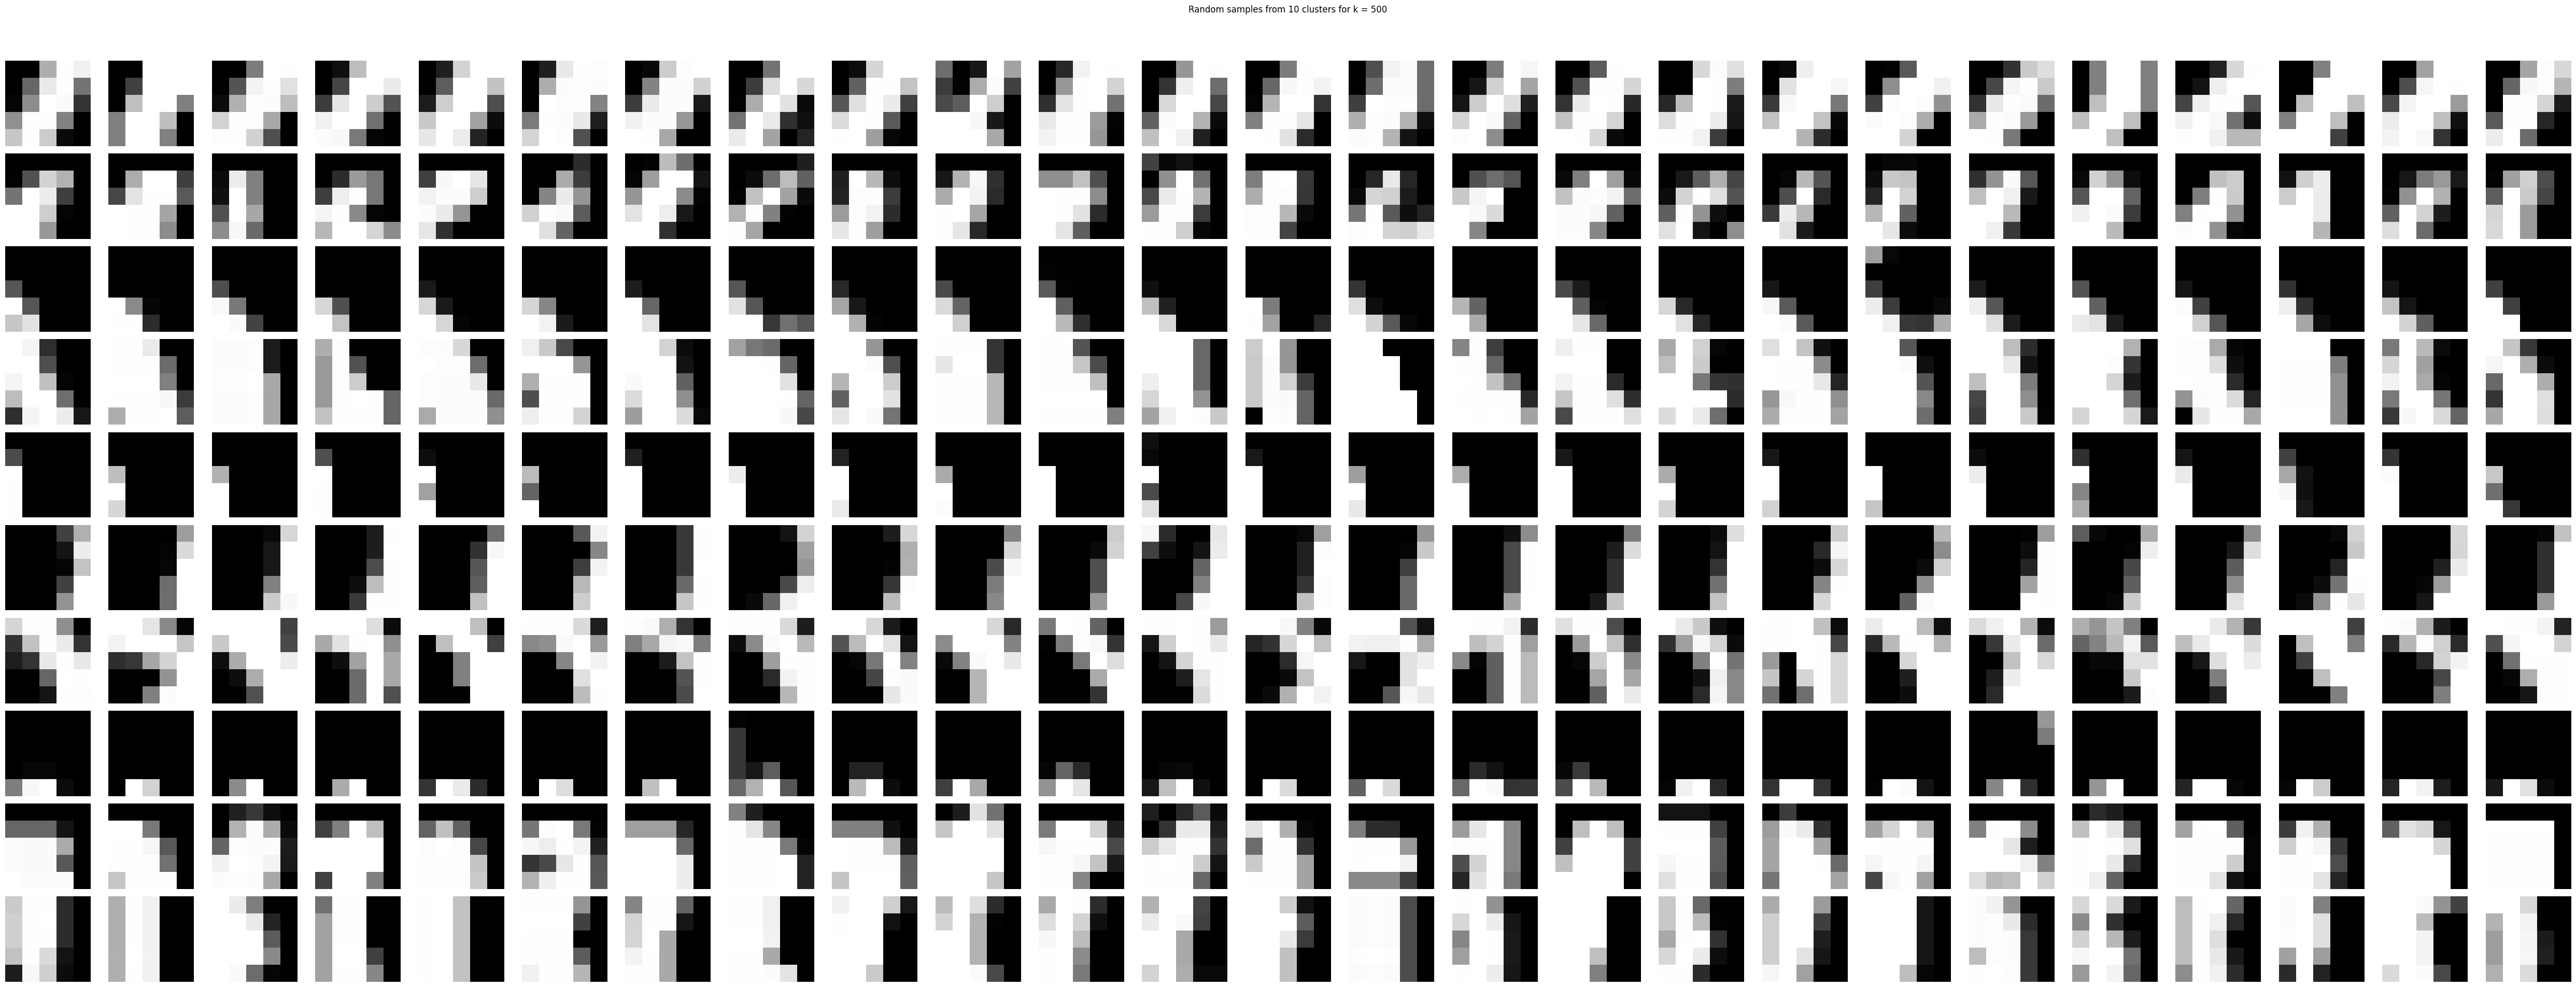

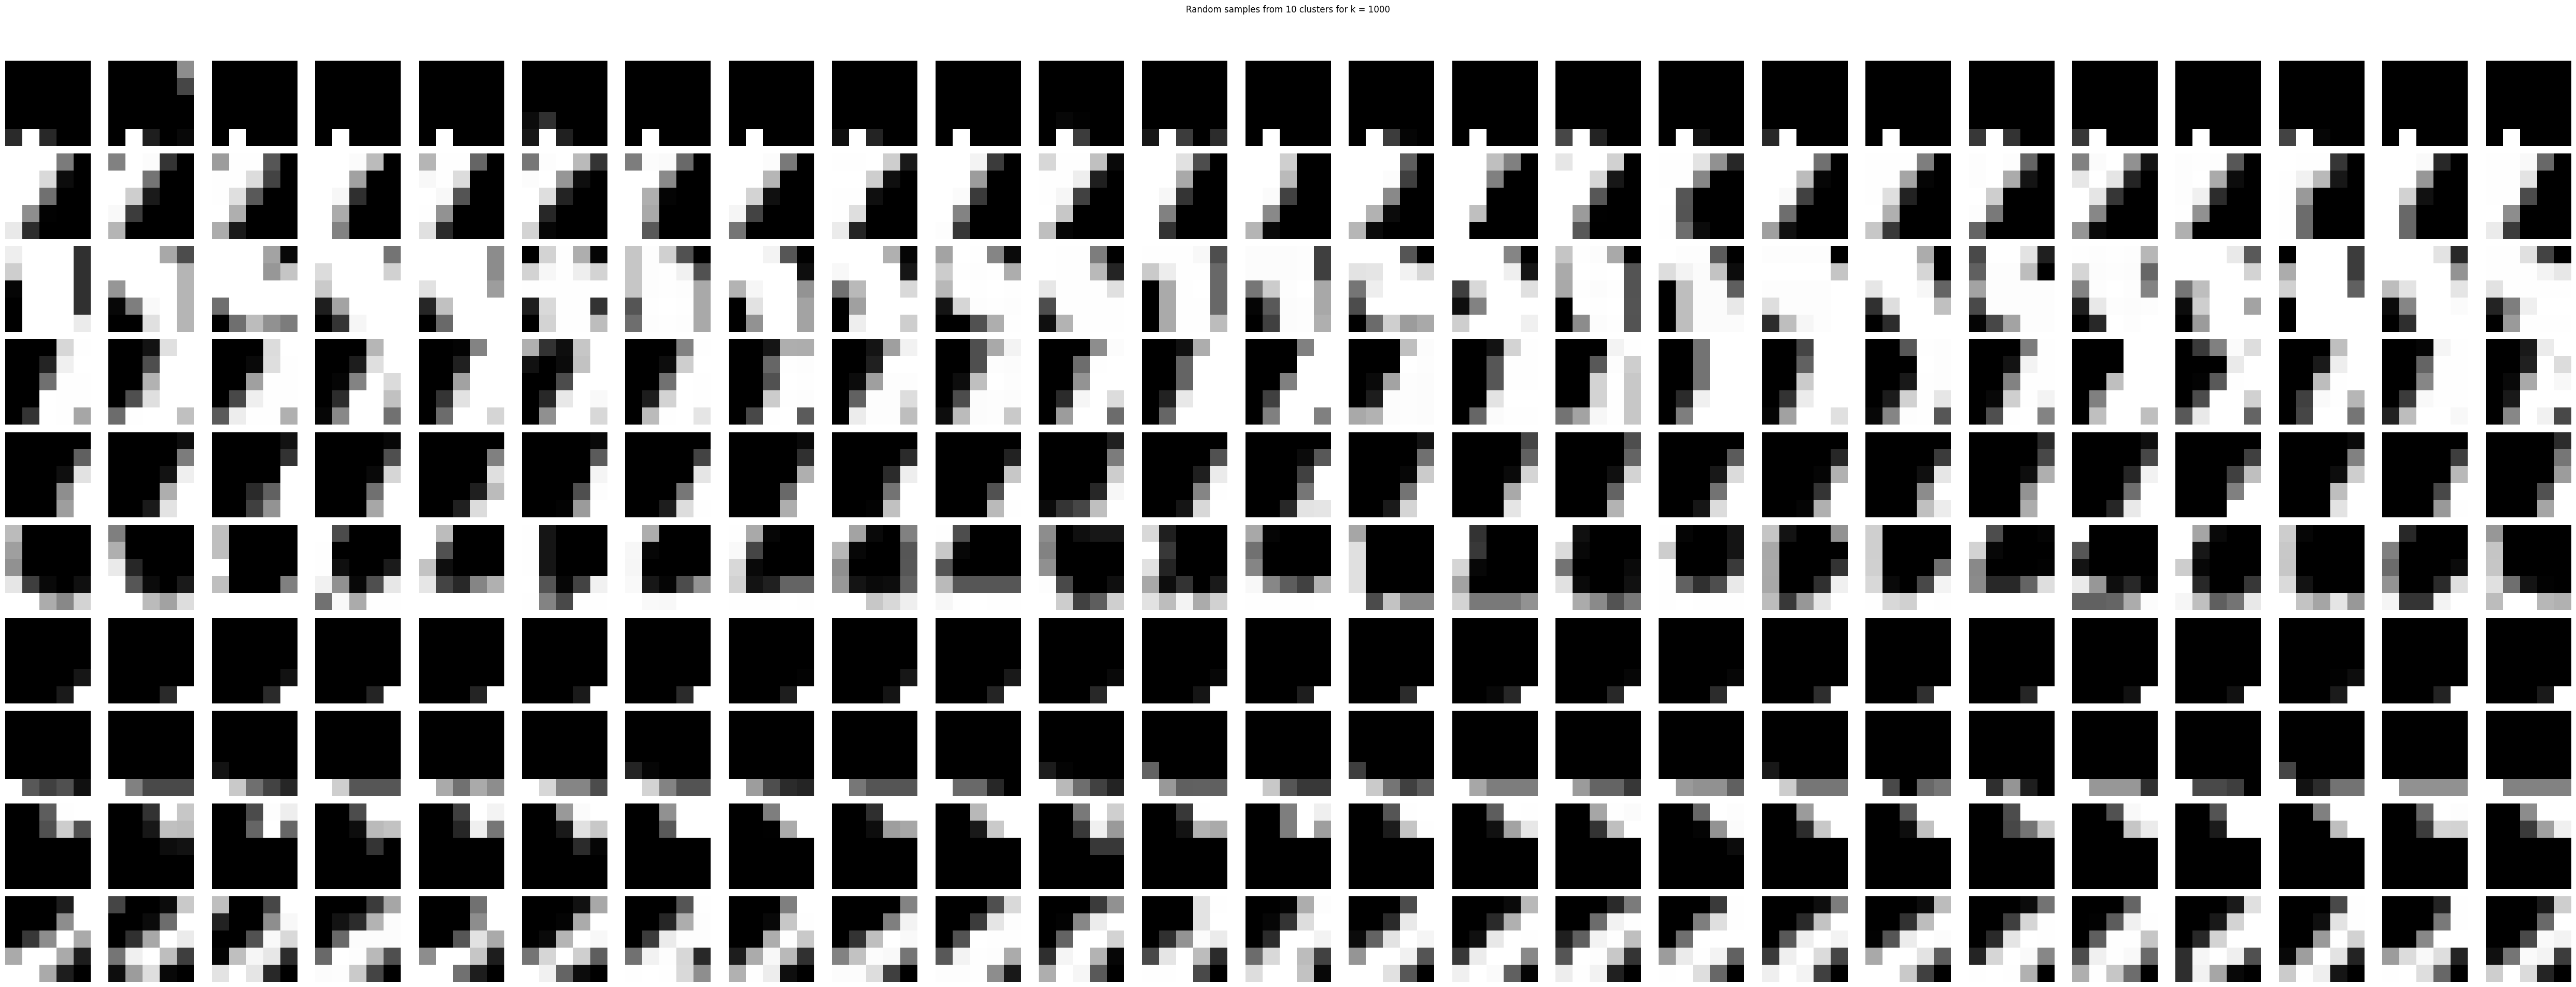

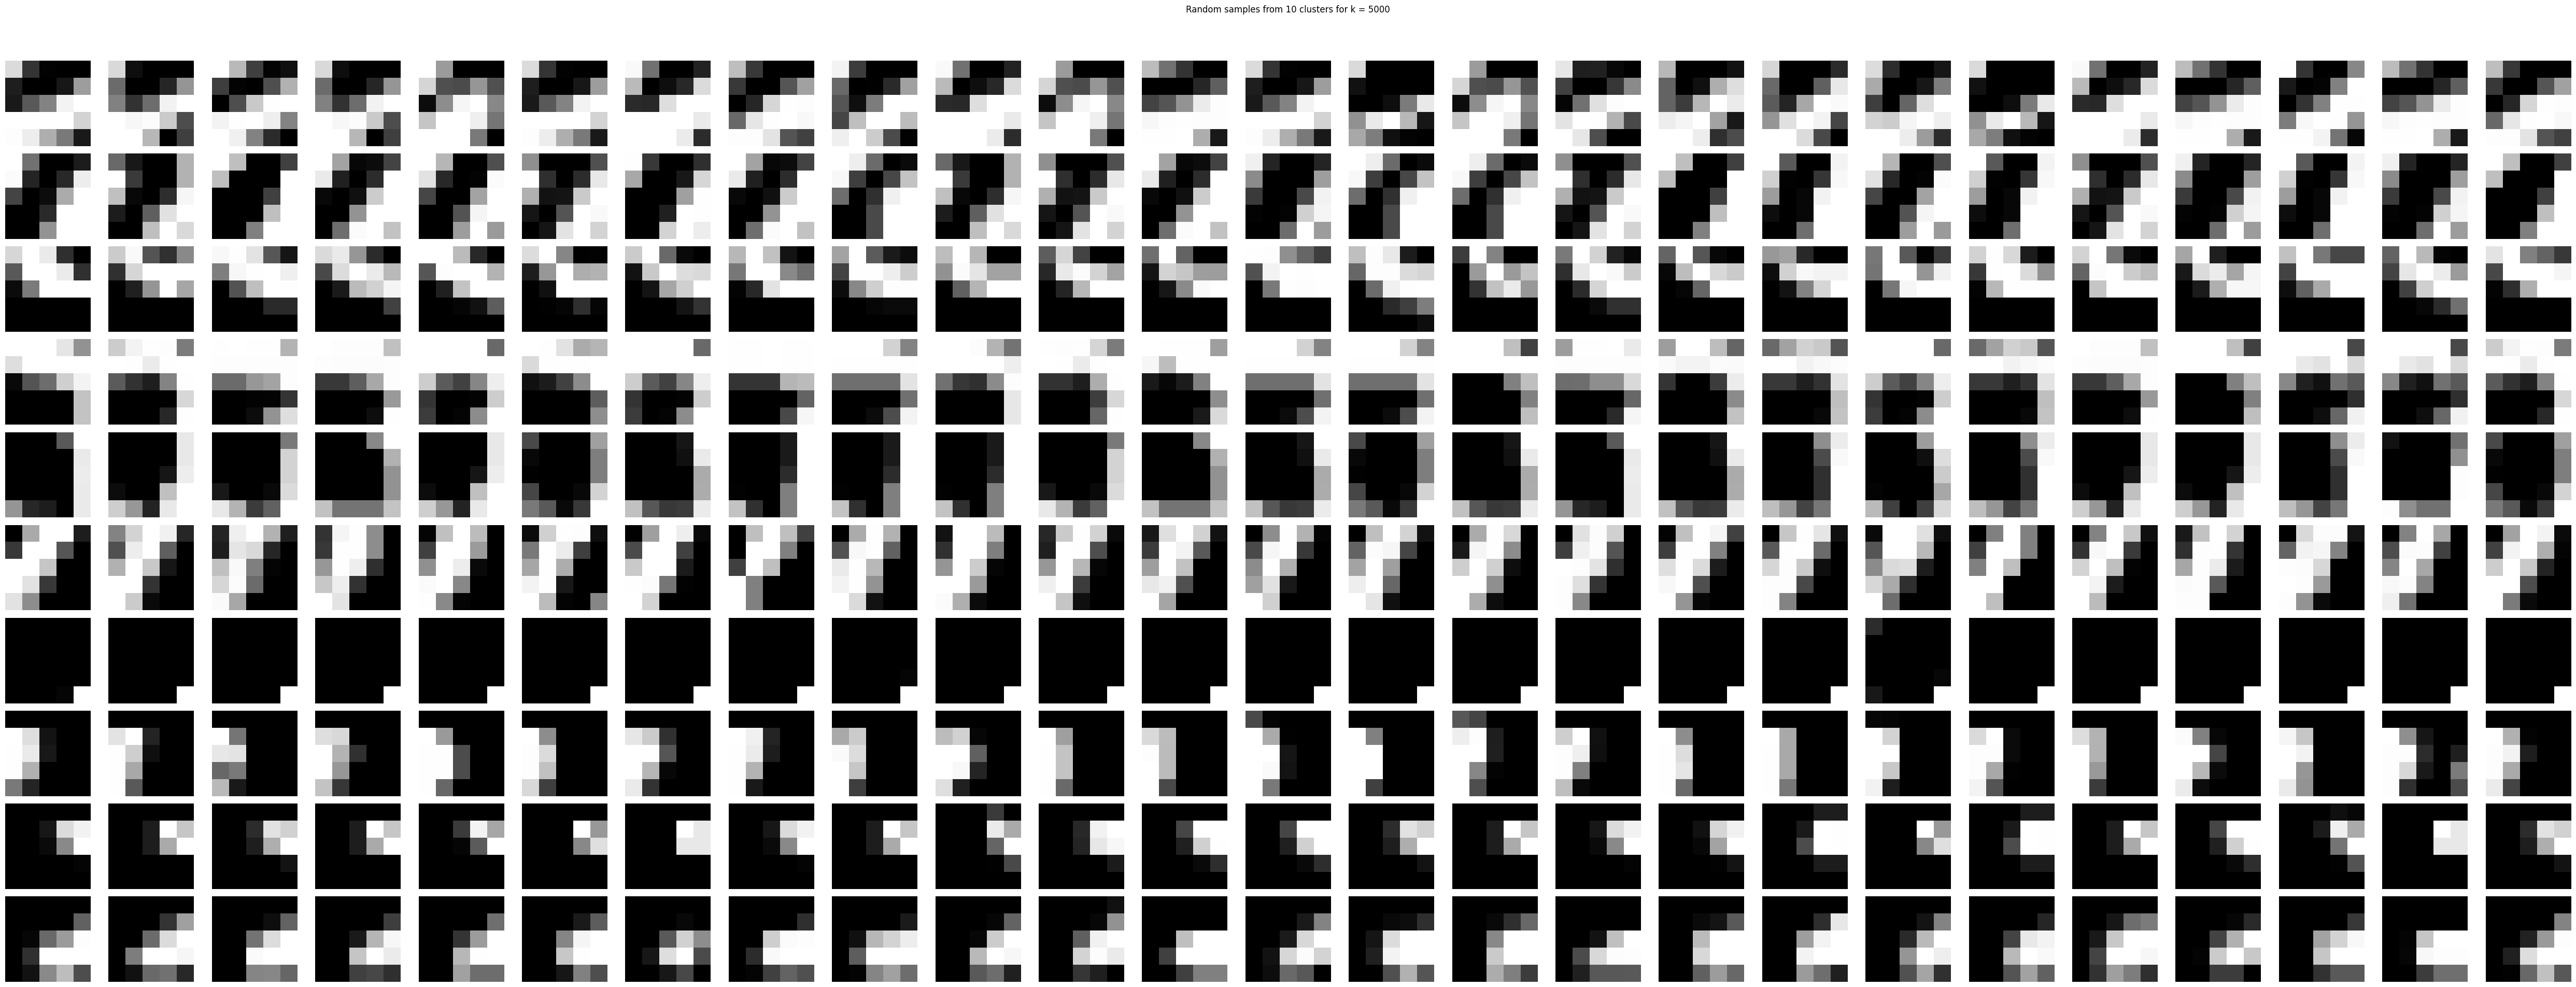

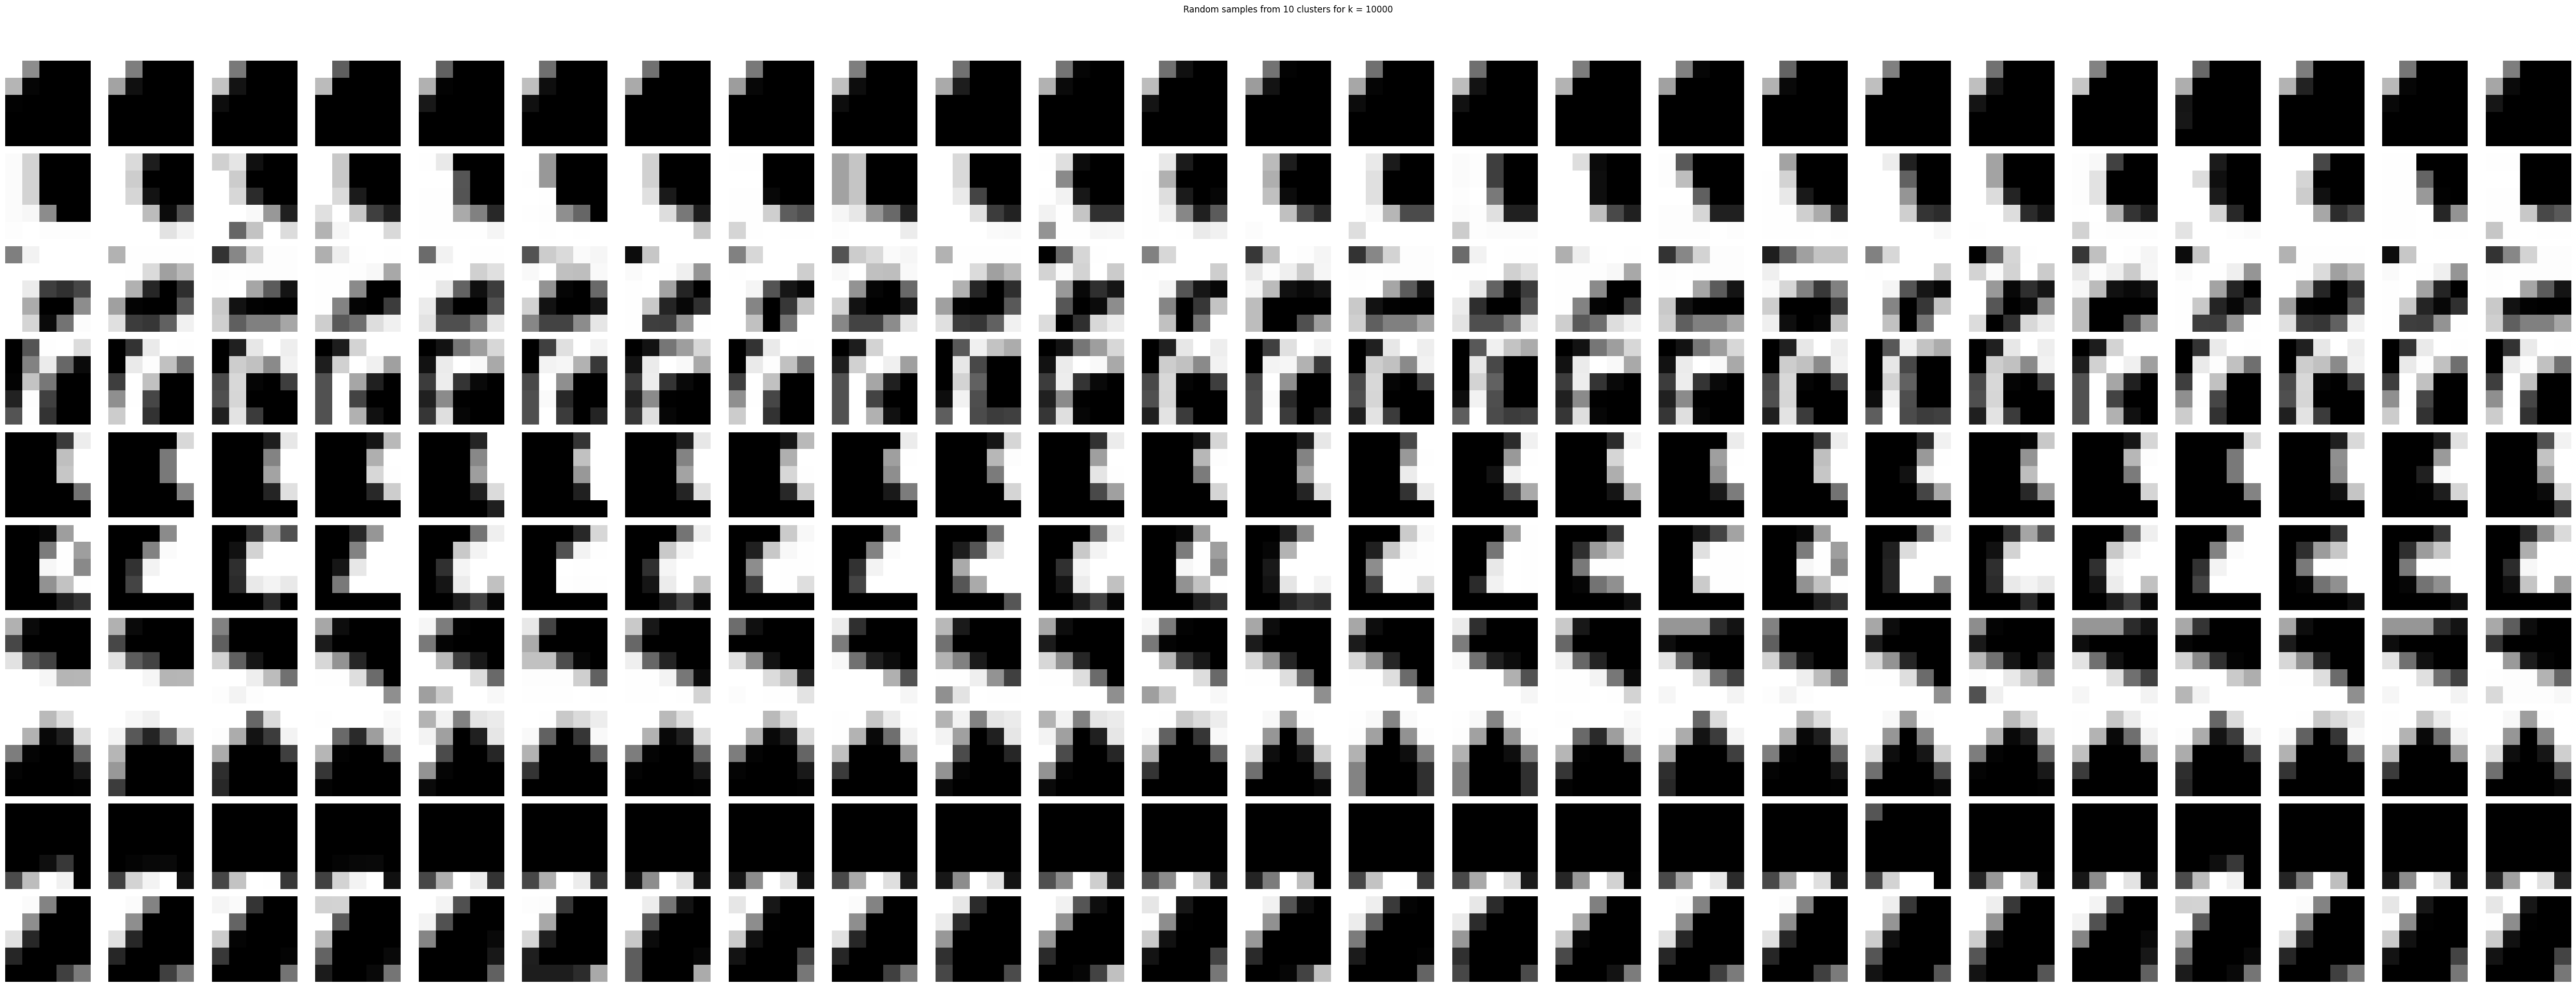

In [12]:
def plot_samples_from_models(models, data, samples_per_cluster=25, clusters_to_sample=10):
    for k, model in models.items():
        # Get cluster labels and the number of clusters
        labels = model.labels_
        num_clusters = model.n_clusters
        
        # Randomly select clusters
        if num_clusters < clusters_to_sample:
            chosen_clusters = np.random.choice(range(num_clusters), clusters_to_sample, replace=True)
        else:
            chosen_clusters = np.random.choice(range(num_clusters), clusters_to_sample, replace=False)
        
        # Prepare the plot
        fig, axs = plt.subplots(clusters_to_sample, samples_per_cluster, figsize=(2*samples_per_cluster, 2*clusters_to_sample))
        plt.suptitle(f'Random samples from {clusters_to_sample} clusters for k = {k}')
        
        for i, cluster_id in enumerate(chosen_clusters):
            cluster_indices = np.where(labels == cluster_id)[0]
            if len(cluster_indices) < samples_per_cluster:
                chosen_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=True)
            else:
                chosen_indices = np.random.choice(cluster_indices, samples_per_cluster, replace=False)
                
            for j, idx in enumerate(chosen_indices):
                patch = data[idx].reshape(5, 5)
                if clusters_to_sample == 1:
                    ax = axs[j]
                else:
                    ax = axs[i, j]
                ax.imshow(patch, cmap='gray', interpolation='nearest')
                ax.axis('off')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_samples_from_models(models, sampled_patches)
